In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
from pathlib import Path
import imghdr
import os

In [144]:
#image directory
#data_dir = "hair_types"
data_dir_train = "/content/drive/MyDrive/coffee_dataset/train"

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir_train).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)



In [145]:
data_dir_test = "/content/drive/MyDrive/coffee_dataset/test"
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir_test).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [146]:
#input selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#added imports
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image

print(tf.__version__)

#CHANGES - seed, batchsize, image size, crop to aspect ratio

image_size = (224, 224) #resizing image to a linear basis
batch_size = 100 #number of images inputed into the network

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

#Input Selection of training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

#Input Selection of validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True
)



2.9.2
Found 400 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
Using 1080 files for training.
Found 1200 files belonging to 4 classes.
Using 120 files for validation.


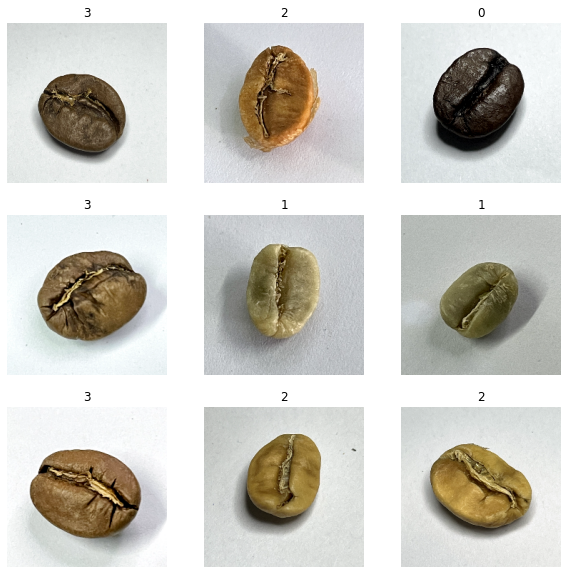

In [147]:
#Visualizing data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(np.argmax(labels[i])))
      plt.axis("off")
plt.show()

# **Transfer Learning**
Frozen Resnet50 layers
*   Added dense (512, Activation = relu)
*   Added dropout (0.5)



In [148]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications import ResNet50, Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

resnet=Sequential()

# Resnet Layer ; Pretrained Model
pretrain = ResNet50(include_top=False,
                    input_shape=(image_size + (3,)),
                    classes=4,
                    weights='imagenet')
# Changed Value of Input layer

# resnet.add(layers.Rescaling(1.0 / 255)) #normalization function

pretrain.trainable = False

# Create new model on top
# inputs = keras.Input(shape=(image_size + (3,)))

# scale_layer = keras.layers.Rescaling(1/ 255)
# x = inputs
# x = scale_layer(x)
# x = pretrain(x, training=False)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
# outputs = Dense(4, activation='softmax')(x)
# model = Model(inputs, outputs) 
# model.summary

for layer in pretrain.layers:
    layer.trainable=False
# dito yata tayo magdagdag ng changes for fine tuning

# Changed Output Layer

# start
resnet.add(keras.layers.Rescaling(1/ 255))
resnet.add(pretrain) #Resnet layer

# Sequential 
resnet.add(Flatten())
resnet.add(Dense(512, activation='relu'))
resnet.add(Dense(256, activation='relu'))
resnet.add(Dropout(0.5))
resnet.add(Dense(4,activation='softmax')) #based on number of classification
# # end

# tf.keras.utils.plot_model(resnet, to_file='model_test_resnet.png', show_shapes=True)
# resnet.summary()


In [149]:
print(pretrain.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

for x, layer in enumerate(pretrain.layers):
  print(x, layer.name, layer.trainable)

In [150]:
from keras.metrics import Precision, Recall

epochs = 10
resnet.compile(optimizer=keras.optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"])
print("Layers Compiled")

Layers Compiled


In [151]:
# Train with freezed resnet
history = resnet.fit(train_ds,epochs=epochs,validation_data=test_ds)
print("Model Trained")

Epoch 1/10
11/11 [==============================] - 13s 702ms/step - loss: 1.6030 - accuracy: 0.3204 - val_loss: 1.1995 - val_accuracy: 0.4775
Epoch 2/10
11/11 [==============================] - 8s 619ms/step - loss: 1.2135 - accuracy: 0.4444 - val_loss: 1.0697 - val_accuracy: 0.5550
Epoch 3/10
11/11 [==============================] - 8s 616ms/step - loss: 1.1029 - accuracy: 0.4926 - val_loss: 0.9572 - val_accuracy: 0.6675
Epoch 4/10
11/11 [==============================] - 8s 601ms/step - loss: 0.9611 - accuracy: 0.5972 - val_loss: 0.8688 - val_accuracy: 0.7575
Epoch 5/10
11/11 [==============================] - 10s 650ms/step - loss: 0.8996 - accuracy: 0.6019 - val_loss: 0.8151 - val_accuracy: 0.7000
Epoch 6/10
11/11 [==============================] - 8s 587ms/step - loss: 0.8266 - accuracy: 0.6500 - val_loss: 0.7723 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 8s 591ms/step - loss: 0.8059 - accuracy: 0.6463 - val_loss: 0.7352 - val_accuracy: 0.7450
Epoc

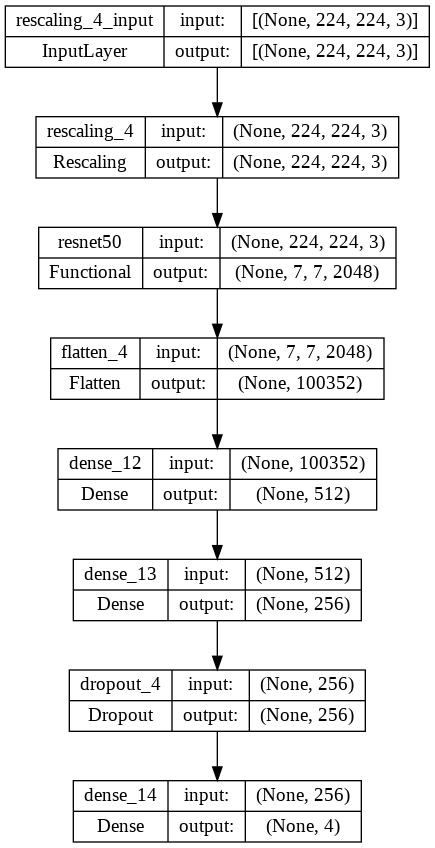

In [152]:
tf.keras.utils.plot_model(resnet, to_file='model_test_resnet.png', show_shapes=True)

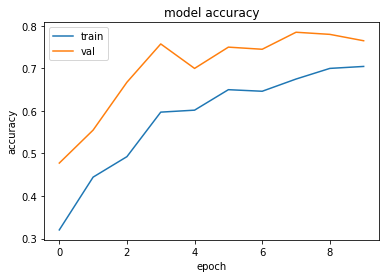

In [153]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

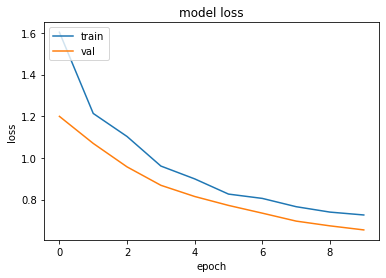

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Fine Tuning
*   Froze 0-164 layers
*   Unfroze 165 - 175 layers



In [155]:
# Unfreeze Layers for Fine-Tuning
for layer in pretrain.layers[:161]: #0 - 170 layers freezed
  layer.trainable = False
for layer in pretrain.layers[161:]: #171 - 175 layers unfreezed
  layer.trainable = True

In [156]:
for x, layer in enumerate(pretrain.layers):
  print(x, layer.name, layer.trainable)

0 input_5 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [157]:
epochs = 50
learningRate = 1e-5
resnet.compile(optimizer=keras.optimizers.Adam(learningRate),loss="categorical_crossentropy",metrics=["accuracy"])
print("Layers Compiled")
print(resnet.summary())

Layers Compiled
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 512)               51380736  
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 4)

In [158]:
# Train with freezed resnet
history = resnet.fit(train_ds,epochs=epochs,validation_data=test_ds)
print("Model Trained")

Epoch 1/50
11/11 [==============================] - 12s 692ms/step - loss: 0.9227 - accuracy: 0.5500 - val_loss: 0.7088 - val_accuracy: 0.6975
Epoch 2/50
11/11 [==============================] - 8s 607ms/step - loss: 0.6227 - accuracy: 0.7343 - val_loss: 0.6952 - val_accuracy: 0.7250
Epoch 3/50
11/11 [==============================] - 8s 609ms/step - loss: 0.5166 - accuracy: 0.7639 - val_loss: 0.7188 - val_accuracy: 0.7350
Epoch 4/50
11/11 [==============================] - 8s 612ms/step - loss: 0.4710 - accuracy: 0.7926 - val_loss: 0.7398 - val_accuracy: 0.6925
Epoch 5/50
11/11 [==============================] - 8s 606ms/step - loss: 0.4094 - accuracy: 0.8333 - val_loss: 0.7819 - val_accuracy: 0.6725
Epoch 6/50
11/11 [==============================] - 8s 596ms/step - loss: 0.3780 - accuracy: 0.8537 - val_loss: 0.8339 - val_accuracy: 0.6075
Epoch 7/50
11/11 [==============================] - 8s 598ms/step - loss: 0.3332 - accuracy: 0.8685 - val_loss: 0.8759 - val_accuracy: 0.5900
Epoch

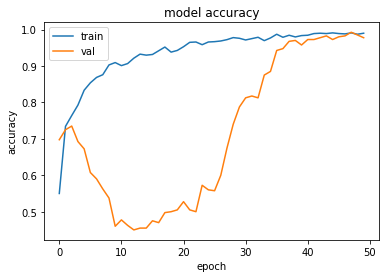

In [159]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

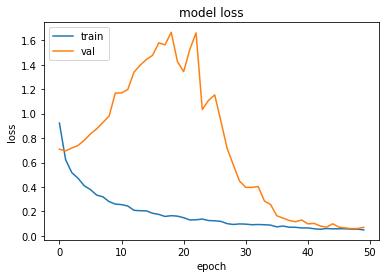

In [160]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [161]:
# from sklearn.metrics import confusion_matrix
# import itertools

# labels = ['Dark', 'Green', 'Light', 'Medium']
# true = 

# cm = confusion_matrix(y_true=val_ds,
#                       y_pred=
#                       );

In [162]:
#@title Combine files
from os import listdir
from os.path import isfile, join

# Dark
darkPath = "/content/drive/MyDrive/coffee_dataset/test/Dark"
darkFiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(darkPath) for f in filenames]
darkFiles.sort()
# print(darkFiles)

# Green
greenPath = "/content/drive/MyDrive/coffee_dataset/test/Green"
greenFiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(greenPath) for f in filenames]
greenFiles.sort()
# print(greenFiles)

# Light
lightPath = "/content/drive/MyDrive/coffee_dataset/test/Light"
lightFiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(lightPath) for f in filenames]
lightFiles.sort()
# print(lightFiles)

# Medium
mediumPath = "/content/drive/MyDrive/coffee_dataset/test/Medium"
mediumFiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(mediumPath) for f in filenames]
mediumFiles.sort()
# print(mediumFiles)

# combine
coffeeFiles = darkFiles + greenFiles + lightFiles + mediumFiles
# print(coffeeFiles)
# print(len(coffeeFiles))

In [163]:
# # using test_ds
# img = keras.preprocessing.image.load_img(
#     "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# for images in test_ds:
  

# predictions = model.predict(img_array)
# print(
#     "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
#     % tuple(predictions[0])
# )

In [164]:
# random image predictor

import random

randomNumber = random.randint(0, len(coffeeFiles)-1)
coffeePath = coffeeFiles[randomNumber]
print(coffeePath)
img = keras.preprocessing.image.load_img(
    str(coffeePath), target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = resnet.predict(img_array)
print(
    "This image is %.2f percent dark, %.2f percent green, %.2f percent light, and %.2f percent medium."
    % tuple(predictions[0])
)

/content/drive/MyDrive/coffee_dataset/test/Medium/medium (2).png
1/1 [==============================] - 1s 1s/step
This image is 0.03 percent dark, 0.00 percent green, 0.00 percent light, and 0.97 percent medium.


In [165]:
# predict all files

for i in range(len(coffeeFiles)):
    print(i)
    coffeePath = coffeeFiles[i]
    print(coffeePath)
    img = keras.preprocessing.image.load_img(
        str(coffeePath), target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = resnet.predict(img_array)
    print(
        "This image is %.2f percent dark, %.2f percent green, %.2f percent light, and %.2f percent medium."
        % tuple(predictions[0])
    )
    i+1

0
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (1).png
1/1 [==============================] - 0s 44ms/step
This image is 1.00 percent dark, 0.00 percent green, 0.00 percent light, and 0.00 percent medium.
1
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (10).png
1/1 [==============================] - 0s 38ms/step
This image is 0.99 percent dark, 0.00 percent green, 0.00 percent light, and 0.01 percent medium.
2
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (100).png
1/1 [==============================] - 0s 48ms/step
This image is 0.99 percent dark, 0.00 percent green, 0.00 percent light, and 0.01 percent medium.
3
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (11).png
1/1 [==============================] - 0s 34ms/step
This image is 1.00 percent dark, 0.00 percent green, 0.00 percent light, and 0.00 percent medium.
4
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (12).png
1/1 [==============================] - 0s 35ms/step
This image is 0.99 percent d

In [166]:
#@title Predict dark files (try lang)
# Predict dark files
 

for i in range(len(darkFiles)):
    print(i)
    eachDarkPath = darkFiles[i]
    print(eachDarkPath)
    img = keras.preprocessing.image.load_img(
        str(eachDarkPath), target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions_dark = resnet.predict(img_array)
    print(
        "This image is %.2f percent dark, %.2f percent green, %.2f percent light, and %.2f percent medium."
        % tuple(predictions_dark[0])
    )
    i+1

0
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (1).png
1/1 [==============================] - 0s 21ms/step
This image is 1.00 percent dark, 0.00 percent green, 0.00 percent light, and 0.00 percent medium.
1
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (10).png
1/1 [==============================] - 0s 23ms/step
This image is 0.99 percent dark, 0.00 percent green, 0.00 percent light, and 0.01 percent medium.
2
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (100).png
1/1 [==============================] - 0s 22ms/step
This image is 0.99 percent dark, 0.00 percent green, 0.00 percent light, and 0.01 percent medium.
3
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (11).png
1/1 [==============================] - 0s 22ms/step
This image is 1.00 percent dark, 0.00 percent green, 0.00 percent light, and 0.00 percent medium.
4
/content/drive/MyDrive/coffee_dataset/test/Dark/dark (12).png
1/1 [==============================] - 0s 23ms/step
This image is 0.99 percent d

In [167]:
#@title (try ulit)
darkValues = []
greenValues = []
lightValues = []
mediumValues = []
y_predict = []  # try for confusion matrix

for i in range(len(coffeeFiles)):
    eachCoffeePath = coffeeFiles[i]
    print(str(i) + "\t"+ eachCoffeePath)
    img = keras.preprocessing.image.load_img(
        str(eachCoffeePath), target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions_coffee = resnet.predict(img_array)
    tupleCoffee = tuple(predictions_coffee[0])
    listCoffee = list(tupleCoffee)
    roundListCoffee = [round(item, 4) for item in listCoffee]
    if(i<=99):
        darkValues.append(roundListCoffee[0])
    elif(99<i<=199):
        greenValues.append(roundListCoffee[1])
    elif(199<i<=299):
        lightValues.append(roundListCoffee[2])
    elif(299<i<=399):
        mediumValues.append(roundListCoffee[3])
    
    # y_predict.append(roundListCoffee.index(max(roundListCoffee)))  # try for confusion matrix
  
    print("Image is " + str(np.round(roundListCoffee[0]*100, decimals=4)) + "% dark, " + str(np.round(roundListCoffee[1]*100, decimals=4)) + "% green, " + 
          str(np.round(roundListCoffee[2]*100, decimals=4)) + "% light, and " + str(np.round(roundListCoffee[3]*100, decimals=4)) + "% medium." + "\n")
    i+1

0	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (1).png
1/1 [==============================] - 0s 24ms/step
Image is 99.96% dark, 0.0% green, 0.0% light, and 0.04% medium.

1	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (10).png
1/1 [==============================] - 0s 23ms/step
Image is 98.97% dark, 0.0% green, 0.01% light, and 1.02% medium.

2	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (100).png
1/1 [==============================] - 0s 23ms/step
Image is 99.49% dark, 0.0% green, 0.0% light, and 0.5% medium.

3	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (11).png
1/1 [==============================] - 0s 24ms/step
Image is 99.91% dark, 0.0% green, 0.0% light, and 0.09% medium.

4	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (12).png
1/1 [==============================] - 0s 21ms/step
Image is 99.13% dark, 0.0% green, 0.0% light, and 0.86% medium.

5	/content/drive/MyDrive/coffee_dataset/test/Dark/dark (13).png
1/1 [==========================

In [168]:
#@title Mean ng green predictions sa green class (not sure kung magagamit)
from statistics import mean 

# print(darkValues)
print("Mean green predictions for dark Images: " + str(round(mean(darkValues),4)))
print("Minimum dark: " + str(min(darkValues)))
print("Minimum at Index " + str(darkValues.index(min(darkValues))))

Mean green predictions for dark Images: 0.9786
Minimum dark: 0.2079
Minimum at Index 15


In [169]:
print("Mean green predictions for Green Images: " + str(round(mean(greenValues),4)))
print("Minimum green: " + str(min(greenValues)))
print("Minimum at Index " + str(greenValues.index(min(greenValues))))

Mean green predictions for Green Images: 0.9854
Minimum green: 0.8844
Minimum at Index 63


In [170]:
print("Mean light predictions for light Images: " + str(round(mean(lightValues),4)))
print("Minimum light: " + str(min(lightValues)))
print("Minimum at Index " + str(lightValues.index(min(lightValues))))

Mean light predictions for light Images: 0.8952
Minimum light: 0.019
Minimum at Index 81


In [171]:
print("Mean medium predictions for medium Images: " + str(round(mean(mediumValues),4)))
print("Minimum medium: " + str(min(mediumValues)))
print("Minimum at Index " + str(mediumValues.index(min(mediumValues))))

Mean medium predictions for medium Images: 0.9609
Minimum medium: 0.4986
Minimum at Index 51
